In [46]:
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import cv2
import os
from numba import jit
from orchard_bouman_clust import clustFunc

In [47]:
def matlab_style_gauss2d(shape=(3, 3), sigma=0.5):
    """
    Returns a 2D Gaussian filter with the specified shape and standard deviation.

    Args:
        shape: A tuple of two integers specifying the dimensions of the output filter. The default value is (3, 3).
        sigma: A float specifying the standard deviation of the Gaussian filter. The default value is 0.5.

    Returns:
        A two-dimensional NumPy array containing the Gaussian filter. The dimensions of the array are determined by
        the shape argument, and the values of the array are determined by the Gaussian function with the specified sigma.
        The sum of the values in the array will be approximately equal to 1.
    """
    m, n = [(ss-1)/2 for ss in shape]
    x, y = np.meshgrid(np.arange(-n, n+1), np.arange(-m, m+1))
    h = np.exp(-(x**2 + y**2)/(2*sigma**2))
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    h /= np.sum(h)
    return h

In [48]:
def show_im(img):
    """
    img - input image should be a numpy array.
    """
    plt.imshow(img)
    plt.show()

In [49]:
@jit(nopython=True, cache=True)
def get_window(image, x_center, y_center, window_size):
    height, width, channels = image.shape
    half_window_size = window_size // 2
    window = np.zeros((window_size, window_size, channels))

    xmin = max(0, x_center - half_window_size)
    xmax = min(width, x_center + (half_window_size + 1))
    ymin = max(0, y_center - half_window_size)
    ymax = min(height, y_center + (half_window_size + 1))

    x_offset_min = half_window_size - (x_center - xmin)
    x_offset_max = half_window_size + (xmax - x_center)
    y_offset_min = half_window_size - (y_center - ymin)
    y_offset_max = half_window_size + (ymax - y_center)

    window[y_offset_min:y_offset_max,
           x_offset_min:x_offset_max] = image[ymin:ymax, xmin:xmax]

    return window

In [50]:
@jit(nopython=True, cache=True)
def solve(mu_F, Sigma_F, mu_B, Sigma_B, C, Sigma_C, alpha_init, maxIter = 50, minLike = 1e-6):
    """
    mu_F - Mean of foreground pixel
    Sigma_F - Covariance Mat of foreground pixel
    mu_B, Sigma_B - Mean and Covariance of background pixel
    C, Sigma_C - Current pixel, and its variance
    alpha_init - starting alpha value
    maxIter - Iterations to solve the value of the pixel
    minLike - min likelihood to reach to stop before maxIterations. 
    """

    # Initializing Matrices
    I = np.eye(3)
    fg_best = np.zeros(3)
    bg_best = np.zeros(3)
    a_best = 0.0
    maxLike = -np.inf
    
    invsgma2 = 1/Sigma_C**2
    
    for i in range(mu_F.shape[0]):
        # Mean of Foreground pixel can have multiple possible values, iterating for all.
        mu_Fi = mu_F[i]
        invSigma_Fi = np.linalg.inv(Sigma_F[i])

        for j in range(mu_B.shape[0]):
            # Similarly, multiple mean values be possible for background pixel.
            mu_Bj = mu_B[j]
            invSigma_Bj = np.linalg.inv(Sigma_B[j])

            alpha = alpha_init
            myiter = 1
            lastLike = -1.7977e+308

            # Solving Minimum likelihood through numerical methods
            while True:
                # Making Equations for AX = b, where we solve for X.abs
                # X here has 3 values of forground pixel (RGB) and 3 values for background
                A = np.zeros((6,6))
                A[:3,:3] = invSigma_Fi + I*alpha**2 * invsgma2
                A[:3,3:] = A[3:,:3] = I*alpha*(1-alpha) * invsgma2
                A[3:,3:] = invSigma_Bj+I*(1-alpha)**2 * invsgma2
                
                b = np.zeros((6,1))
                b[:3] = np.reshape(invSigma_Fi @ mu_Fi + C*(alpha) * invsgma2,(3,1))
                b[3:] = np.reshape(invSigma_Bj @ mu_Bj + C*(1-alpha) * invsgma2,(3,1))

                # Solving for X and storing values for Forground and Background Pixels 
                X = np.linalg.solve(A, b)
                F = np.maximum(0, np.minimum(1, X[0:3]))
                B = np.maximum(0, np.minimum(1, X[3:6]))
                
                # Solving for value of alpha once F and B are calculated
                alpha = np.maximum(0, np.minimum(1, ((np.atleast_2d(C).T-B).T @ (F-B))/np.sum((F-B)**2)))[0,0]
                
                # Calculating likelihood value for
                like_C = - np.sum((np.atleast_2d(C).T -alpha*F-(1-alpha)*B)**2) * invsgma2
                like_fg = (- ((F- np.atleast_2d(mu_Fi).T).T @ invSigma_Fi @ (F-np.atleast_2d(mu_Fi).T))/2)[0,0]
                like_bg = (- ((B- np.atleast_2d(mu_Bj).T).T @ invSigma_Bj @ (B-np.atleast_2d(mu_Bj).T))/2)[0,0]
                like = (like_C + like_fg + like_bg)

                if like > maxLike:
                    a_best = alpha
                    maxLike = like
                    fg_best = F.ravel()
                    bg_best = B.ravel()

                if myiter >= maxIter or abs(like-lastLike) <= minLike:
                    break

                lastLike = like
                myiter += 1
    return fg_best, bg_best, a_best 

In [51]:
def Bayesian_Matte(img, trimap, N=105, sig=8, minNeighbours=10):
    '''
    img - input image that the user will give to perform the foreground-background mapping
    trimap - the alpha mapping that is given with foreground and background determined.
    N - Window size, determines how many pixels will be sampled around the pixel to be solved, should be always odd.
    sig - wieghts of the neighbouring pixels. less means more centered.
    minNeighbours - Neigbour pixels available to solve, should be greater than 0, else inverse wont be calculated
    '''

    # We Convert the Images to float so that we are able to play with the pixel values
    img = np.array(img, dtype='float')
    trimap = np.array(image_trimap, dtype='float')

    # Here we normalise the Images to range from 0 and 1.
    img /= 255
    trimap /= 255

    # We get the dimensions
    h, w, c = img.shape

    # Preparing the gaussian weights for window
    gaussian_weights = matlab_style_gauss2d((N, N), sig)
    gaussian_weights /= np.max(gaussian_weights)

    # We seperate the foreground specified in the trimap from the main image.
    fg_map = trimap == 1
    fg_actual = np.zeros((h, w, c))
    fg_actual = img * np.reshape(fg_map, (h, w, 1))

    # We seperate the background specified in the trimap from the main image.
    bg_map = trimap == 0
    bg_actual = np.zeros((h, w, c))
    bg_actual = img * np.reshape(bg_map, (h, w, 1))

    # Creating empty alpha channel to fill in by the program
    unknown_map = np.logical_or(fg_map, bg_map) == False
    a_channel = np.zeros(unknown_map.shape)
    a_channel[fg_map] = 1
    a_channel[unknown_map] = np.nan

    # Finding total number of unkown pixels to be calculated
    n_unknown = np.sum(unknown_map)

    # Making the datastructure for finding pixel values and saving id they have been solved yet or not.
    A, B = np.where(unknown_map == True)
    not_visited = np.vstack((A, B, np.zeros(A.shape))).T

    print("Solving Image with {} unsovled pixels... Please wait...".format(len))

    # running till all the pixels are solved.
    while(sum(not_visited[:, 2]) != n_unknown):
        last_n = sum(not_visited[:, 2])

        # iterating for all pixels
        for i in range(n_unknown):
            # checking if solved or not
            if not_visited[i, 2] == 1:
                continue

            # If not solved, we try to solve
            else:
                # We get the location of the unsolved pixel
                y, x = map(int, not_visited[i, :2])

                # Creating an window which states what pixels around it are solved(forground/background)
                a_window = get_window(
                    a_channel[:, :, np.newaxis], x, y, N)[:, :, 0]

                # Creating a window and weights of solved foreground window
                fg_window = get_window(fg_actual, x, y, N)
                fg_weights = np.reshape(a_window**2 * gaussian_weights, -1)
                values_to_keep = np.nan_to_num(fg_weights) > 0
                fg_pixels = np.reshape(fg_window, (-1, 3))[values_to_keep, :]
                fg_weights = fg_weights[values_to_keep]

                # Creating a window and weights of solved background window
                bg_window = get_window(bg_actual, x, y, N)
                bg_weights = np.reshape((1-a_window)**2 * gaussian_weights, -1)
                values_to_keep = np.nan_to_num(bg_weights) > 0
                bg_pixels = np.reshape(bg_window, (-1, 3))[values_to_keep, :]
                bg_weights = bg_weights[values_to_keep]

                # We come back to this pixel later if it doesnt has enough solved pixels around it.
                if len(bg_weights) < minNeighbours or len(fg_weights) < minNeighbours:
                    continue

                # If enough pixels, we cluster these pixels to get clustered colour centers and their covariance    matrices
                mean_fg, cov_fg = clustFunc(fg_pixels, fg_weights)
                mean_bg, cov_bg = clustFunc(bg_pixels, bg_weights)
                alpha_init = np.nanmean(a_window.ravel())

                # We try to solve our 3 equation 7 variable problem with minimum likelihood estimation
                fg_pred, bg_pred, alpha_pred = solve(
                    mean_fg, cov_fg, mean_bg, cov_bg, img[y, x], 0.7, alpha_init)

                # storing the predicted values in appropriate windows for use for later pixels.
                fg_actual[y, x] = fg_pred.ravel()
                bg_actual[y, x] = bg_pred.ravel()
                a_channel[y, x] = alpha_pred
                not_visited[i, 2] = 1
                if(np.sum(not_visited[:, 2]) % 1000 == 0):
                    print("Solved {} out of {}.".format(
                        np.sum(not_visited[:, 2]), len(not_visited)))

        if sum(not_visited[:, 2]) == last_n:
            # ChangingWindow Size
            # Preparing the gaussian weights for window
            N += 2
            # sig += 1
            gaussian_weights = matlab_style_gauss2d((N, N), sig)
            gaussian_weights /= np.max(gaussian_weights)
            print(N)

    return a_channel, n_unknown

In [52]:
def image_composite(foreground, background, alpha):
        
    alpha = np.array(alpha)

    # Normalize the alpha matte to have values between 0 and 1
    #alpha = alpha.astype(np.float32) / 255.0

    # Create the composite image
    composite = alpha * foreground + (1 - alpha) * background

    # Display the composite image
    plt.imshow(composite, cmap='gray')
    plt.show()

Solving Image with <built-in function len> unsovled pixels... Please wait...
Solved 1000.0 out of 111308.
Solved 2000.0 out of 111308.
Solved 3000.0 out of 111308.
Solved 4000.0 out of 111308.
Solved 5000.0 out of 111308.
Solved 6000.0 out of 111308.
Solved 7000.0 out of 111308.
Solved 8000.0 out of 111308.
Solved 9000.0 out of 111308.
Solved 10000.0 out of 111308.
Solved 11000.0 out of 111308.
Solved 12000.0 out of 111308.
Solved 13000.0 out of 111308.
Solved 14000.0 out of 111308.
Solved 15000.0 out of 111308.
Solved 16000.0 out of 111308.
Solved 17000.0 out of 111308.
Solved 18000.0 out of 111308.
Solved 19000.0 out of 111308.
Solved 20000.0 out of 111308.
Solved 21000.0 out of 111308.
Solved 22000.0 out of 111308.
Solved 23000.0 out of 111308.
Solved 24000.0 out of 111308.
Solved 25000.0 out of 111308.
Solved 26000.0 out of 111308.
Solved 27000.0 out of 111308.
Solved 28000.0 out of 111308.
Solved 29000.0 out of 111308.
Solved 30000.0 out of 111308.
Solved 31000.0 out of 111308.
So

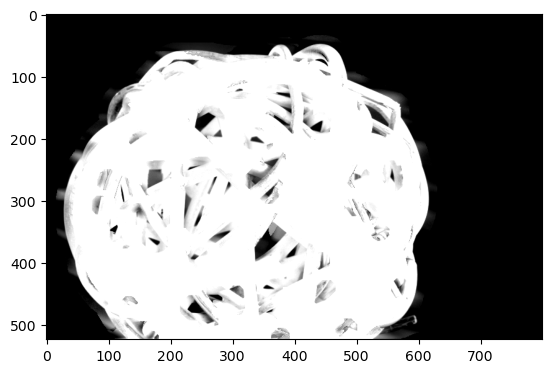

Absolute Loss with ground truth -  6.316833597650653


In [57]:
image = np.array(Image.open('C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/input_training_lowres/GT02.png'))
image_trimap = np.array(ImageOps.grayscale(Image.open('C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/trimap_training_lowres/Trimap2/GT02.png')))

alpha, pixel_count = Bayesian_Matte(image, image_trimap)


image_alpha = np.array(ImageOps.grayscale(Image.open('C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/gt_training_lowres/GT02.png')))

alpha = alpha*255
plt.imshow(alpha, cmap='gray')
plt.show()

print("Absolute Loss with ground truth - ",
      np.sum(np.abs(alpha - image_alpha))/(alpha.shape[0]*alpha.shape[1]))

# # Convert alpha to 3 channels
# alpha = np.dstack((alpha, alpha, alpha))

# # # Load the foreground and background images
# foreground = image
# background = np.array(Image.open('C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/background.jpg'))
# foreground_shape = foreground.shape
# background = np.resize(background, foreground_shape)
# image_composite(foreground, background, alpha)



# print(foreground.shape)
# print(background.shape)
# print(alpha.shape)


In [54]:
import numpy as np
from PIL import Image


# Load the foreground, background, and alpha images
foreground = np.array(Image.open('C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/input_training_lowres/GT02.png'))
background = np.array(Image.open('background.jpg'))
background = np.resize(background, foreground.shape)
alpha = np.array(alpha)

print(alpha.shape)
print(alpha.dtype)

# Scale the alpha values from [0, 255] to [0, 1]
alpha = alpha.astype(float) / 255

# Normalize the foreground and background images to [0, 1]
foreground = foreground.astype(float) / 255
background = background.astype(float) / 255

# Create the composite image
composite = alpha * foreground + (1 - alpha) * background

# Save the composite image
composite = (composite*255).astype(np.uint8)
Image.fromarray(composite).save('composite.png')

# Display the foreground, background, and composite images
plt.subplot(1, 3, 1)
plt.imshow(foreground)
plt.axis('off')
plt.subplot(1, 3, 2)
plt.imshow(background)
plt.axis('off')
plt.subplot(1, 3, 3)
plt.imshow(composite)
plt.axis('off')
plt.show()


(800, 640)
float64


ValueError: operands could not be broadcast together with shapes (800,640) (524,800,3) 

In [ ]:
import os
from PIL import Image, ImageOps
import numpy as np

# Define the paths to the folders
image_folder = 'C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/input_training_lowres/'
trimap_folder = 'C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/trimap_training_lowres/Trimap2/'
alpha_folder = 'C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/gt_training_lowres/'

# Iterate through all the files in the folders
for filename in os.listdir(image_folder):
    if filename.endswith('.png'):
        # Read the image, trimap, and alpha files
        image_path = os.path.join(image_folder, filename)
        image = np.array(Image.open(image_path))
        
        trimap_path = os.path.join(trimap_folder, filename)
        image_trimap = np.array(ImageOps.grayscale(Image.open(trimap_path)))
        
        alpha_path = os.path.join(alpha_folder, filename)
        image_alpha = np.array(ImageOps.grayscale(Image.open(alpha_path)))
        
        # Perform the Bayesian matte calculation
        alpha, pixel_count = Bayesian_Matte(image, image_trimap)
        alpha = alpha*255
        
        # Do something with the resulting alpha channel, e.g. save it
        result_path = os.path.join('C:/Users/labanr/Desktop/Matting/Bayesian-Matting/Bayesian_Matting_Python/results/', filename)
        Image.fromarray(alpha.astype(np.uint8)).save(result_path)

Solving Image with <built-in function len> unsovled pixels... Please wait...
Solved 1000.0 out of 67603.
Solved 2000.0 out of 67603.
Solved 3000.0 out of 67603.
Solved 4000.0 out of 67603.
Solved 5000.0 out of 67603.
Solved 6000.0 out of 67603.
Solved 7000.0 out of 67603.
Solved 8000.0 out of 67603.
Solved 9000.0 out of 67603.
Solved 10000.0 out of 67603.
Solved 11000.0 out of 67603.
Solved 12000.0 out of 67603.
Solved 13000.0 out of 67603.
Solved 14000.0 out of 67603.
Solved 15000.0 out of 67603.
Solved 16000.0 out of 67603.
Solved 17000.0 out of 67603.
Solved 18000.0 out of 67603.
Solved 19000.0 out of 67603.
Solved 20000.0 out of 67603.
Solved 21000.0 out of 67603.
Solved 22000.0 out of 67603.
Solved 23000.0 out of 67603.
Solved 24000.0 out of 67603.
Solved 25000.0 out of 67603.
Solved 26000.0 out of 67603.
Solved 27000.0 out of 67603.
Solved 28000.0 out of 67603.
Solved 29000.0 out of 67603.
Solved 30000.0 out of 67603.
Solved 31000.0 out of 67603.
Solved 32000.0 out of 67603.
Solv

KeyboardInterrupt: 